In [ ]:
print("init...")
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")
print("init done.")



init...
init done.


In [ ]:
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

            Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-07-13   11422
2020-07-14   11597
2020-07-15   11753
2020-07-16   11920
2020-07-17   12106

[178 rows x 1 columns]
            Deaths
Date              
2020-07-18   12228
2020-07-19   12323
2020-07-20   12408
2020-07-21   12561
2020-07-22   12726
2020-07-23   12873
2020-07-24   13026
2020-07-25   13172
2020-07-26   13249
2020-07-27   13334


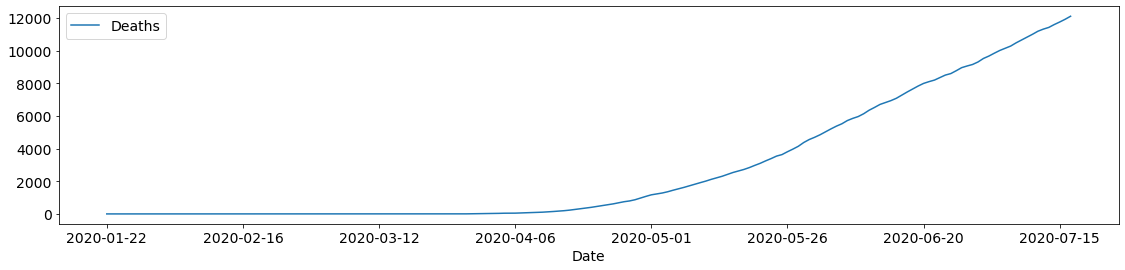

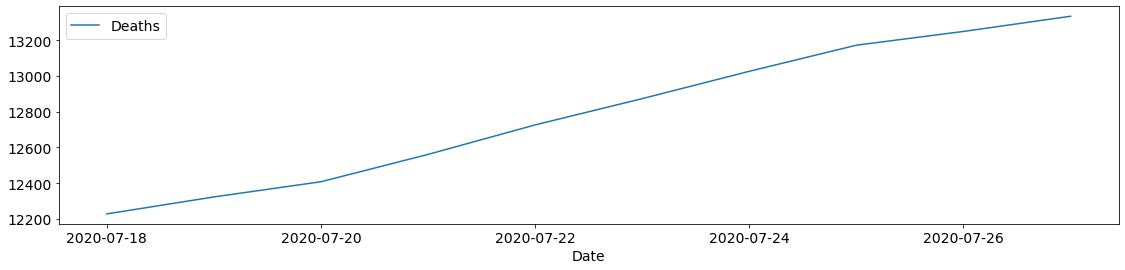

In [ ]:
data=pd.read_csv("data/full_grouped.csv")
data=data.loc[data['Country/Region'] == "Russia"]
data.drop("Country/Region",1, inplace=True)
data.drop("WHO Region",1, inplace=True)
y=data.loc[:,["Date","Deaths"]]
y=y.set_index(["Date"])
y2=y.copy()
y2=y2[-10:]
y=y[:-10]
print(y)
print(y2)
y.plot(figsize=(19,4))
y2.plot(figsize=(19,4))
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [117]:
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))
# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(y, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
               # Estimate the model with missing datapoints
        mod = sm.tsa.statespace.SARIMAX(y2, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_miss.iloc[p,q] = res.aic
        except:
            aic_miss.iloc[p,q] = np.nan


In [124]:
print(aic_full,"\n")
aic_filter=np.nan_to_num(aic_full)
i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_full[j[0]][i[0]])
print("ARIMA(%s,%s)"%(i[0],j[0]))

             0            1            2            3            4  \
0     0.000000  3390.155867  3049.935638  3098.252797  3317.478960   
1  2155.322532  1970.693577  1865.301680  1828.226256  1774.115332   
2  1665.685637  1226.970091  1984.840135  1714.999504  1829.592968   
3  1660.710101  1669.717442  1681.968704  1636.394889  1631.741295   
4  1686.934326  1709.431482  1678.188787  1650.392958  1644.962488   
5  1692.294713  1689.876367  1689.359837  1678.614609  1690.101744   

             5  
0  3462.438700  
1  1751.990599  
2  1775.886995  
3  1719.356052  
4  1685.159203  
5  1729.900662   

min aic[1][2]: 1226.9700914663417
ARIMA(2,1)


In [123]:
print(aic_miss,"\n")
aic_filter=np.nan_to_num(aic_miss)
i,j=np.where(aic_filter==np.min(aic_filter[np.nonzero(aic_filter)]))
print("min aic[%s][%s]:"%(j[0],i[0]) ,aic_miss[j[0]][i[0]])
print("ARIMA(%s,%s)"%(i[0],j[0]))

            0           1           2           3           4           5
0    0.000000  215.983342  205.694266  349.453652  192.216678  187.851766
1  138.561986  132.232840  134.527321  130.170282  128.521992  133.587861
2         NaN   94.865229  153.776016  134.955441  133.214569  144.913326
3  121.347284  131.998847  208.043391  157.567471  155.434703  160.232318
4  123.046367  125.292485  140.493684  161.730396  160.829281  162.130206
5         NaN   14.000000  217.664634  163.330263  162.892193  164.240061 

min aic[1][5]: 14.0
ARIMA(5,1)


In [131]:
mod = sm.tsa.statespace.SARIMAX(y, order=(i[0],0,j[0]))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  178
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -812.106
Date:                Wed, 29 Dec 2021   AIC                           1632.212
Time:                        01:09:31   BIC                           1644.940
Sample:                    01-22-2020   HQIC                          1637.374
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9973      0.005    422.946      0.000       1.988       2.007
ar.L2         -0.9974      0.005   -208.214      0.000      -1.007      -0.988
ma.L1         -0.6977      0.043    -16.251      0.0

TypeError: '(slice(None, None, None), 0)' is an invalid key

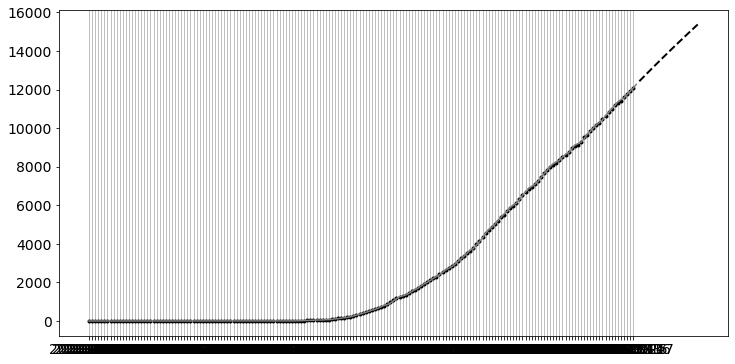

In [132]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(y, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

ax.set(title='Figure 8.9 - Internet series')